# 🌊 Deep Dive Into Isolation Forest
> **작성자 : 오수지 (2022020660)**

안녕하세요, 고려대학교 산업경영공학부 DSBA 연구실 석사과정 오수지입니다.  
이번 노트북 튜토리얼에선 Model-based Anomaly Detection 방법론, 그 중에서도 **`Isolation Forest`**에 대해 코드를 통해 알아볼 예정입니다. (🔎 Anomaly Detection에 대한 기본적인 내용은 [유튜브 튜토리얼 영상](https://youtu.be/XshinhpMrLQ)을 참고해주세요.)

Isolation Forest는 매우 직관적이고, 이상치 탐지 대회에서 아직까지도 많이 사용되고 있는 방법론인데요! 여러 개의 Decision Tree를 지속적으로 분기시키면서 모든 데이터 관측치의 고립 정도 여부에 따라 이상치를 판별하는 방법입니다. 쉽게 생각해보자면 이상치 데이터일수록 다른 정상 데이터와 다른 특성을 띌테니 빨리 고립될 것이고, 정상 데이터일수록 서로서로 비슷비슷할테니 늦게 고립되겠죠?! 즉, **특정 데이터가 고립되는 leaf node까지의 거리**를 `Anomaly Score`로 정의하고, 일찍 고립될수록, 즉 root node로부터 leaf node까지의 평균 거리가 짧을수록 anomaly score가 높아지게 됩니다.

근데 수업을 들으면서도, 유튜브 동영상을 만들면서도 전 한 가지 의문점이 들었습니다. 분기의 기준이 되는 Attribute를 랜덤하게 선택하지 않으면 어떨까요?  Isolation Forest는 Decision Tree를 기반으로 하는 방법론이고, Decision Tree의 분기 기준은 Information gain, Gini Impurity, Chi-Square 등 여러가지가 있는만큼 만약 랜덤하게 하지 않으면 결과가 달라지지 않을까요?

그러기 위해서 일단 (1) Isolation Forest를 Scratch부터 구현한 레포를 pseudo code와 대조해가며 line by line으로 이해를 하고, (2) Information Gain을 기준으로 분기하는 코드를 추가한 다음 (3) 두 방식간 성능 차이를 확인해보겠습니다 😀

<img src="images/if.png" width="600">

**📌 이번 튜토리얼의 목표**
>1. Isolation Forest from Scratch
>2. Isolation Forest without Randomness from Scratch
>3. 1, 2번 간 성능 비교

**📌 Reference**
- https://github.com/mgckind/iso_forest
- https://github.com/sahandha/eif
- https://hongl.tistory.com/150

## 🛠 환경 설정

In [1]:
import numpy as np
import pandas as pd
import random
import math
from tqdm.auto import tqdm
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings
warnings.filterwarnings(action='ignore') 
import copy
import seaborn as sb
import matplotlib.pyplot as plt
sb.set_style(style="whitegrid")
sb.set_color_codes()
from sklearn.metrics import f1_score

In [2]:
def seed_everything(seed: int = 1201):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything()

## 1️⃣ 데이터 준비
> Dacon에서 열린 **`월간 데이콘 신용카드 사기 거래 탐지 AI 경진대회`**의 신용카드 거래 데이터를 사용하겠습니다! (대회에서 제공한 데이터의 원 출처는 대회 데이터 설명 탭에 나와있습니다.) 

**1. 학습(Train) 데이터셋 (113842개)**  

파일명: train.csv  
설명: 정상, 사기 거래의 여부를 알 수 없는(대부분 정상 거래) 신용 카드 데이터 (Unlabeled)  
ID : 신용 카드 거래 ID  
Column ('V1', 'V2', 'V3', ... ,'V30) : 비식별화된 신용 카드 거래 Feature  


**2. 검증(Validation) 데이터셋 (28462개)**   

파일명: val.csv  
설명: 정상, 사기 거래의 여부가 포함된 신용 카드 데이터
ID : 신용 카드 거래 ID   
Column ('V1', 'V2', 'V3', ... ,'V30) : 비식별화된 신용 카드 거래 Feature  
Class : 신용 카드 거래의 정상, 사기 여부 (정상 : 0, 사기 : 1)  

In [3]:
train_dataset = pd.read_csv("./data/credit_card_fraud_detection/train.csv")
val_dataset = pd.read_csv("./data/credit_card_fraud_detection/val.csv")

In [4]:
train_dataset = train_dataset.drop(columns=['ID'])
val_dataset_label = val_dataset['Class']
val_dataset_attributes = val_dataset.drop(columns=['Class', 'ID'])

## 1️⃣ Isolation Forest from Scratch
> 코드는 https://github.com/mgckind/iso_forest 에서 가져왔습니다. 다만, 코드에 주석이 없어 알고리즘을 알고 코드를 봐도 이해가 어렵습니다. 그래서 본 목차는 위의 코드를 기반으로 신용카드 거래 데이터셋에 맞는 추가적인 리팩토링 및 pseudo code와 함께 line by line으로 함께 이해하는 것이 목표입니다.

### 🔎 Node
> Tree의 각 Node에는 어떤 정보가 포함될까요?
- 여기서 `External Node`란 자식 노드가 없는 노드(즉, Leaf Node), `Internal Node`란 적어도 하나의 자식 노드가 있는 노드를 뜻합니다.

In [5]:
class Node(object):
    def __init__(self, X, q, p, e, left, right, node_type = ''):
        self.e = e  # 현재 tree height
        self.size = len(X) # 데이터에 포함된 object 개수
        self.q = q  # split attribute
        self.p = p  # split point
        self.left = left  # 현재 Node의 Left Node
        self.right = right  # 현재 Node의 Right Node
        self.ntype = node_type  # 현재 Node의 Type (External Node or Internal Node)

### 🔎 iTree
<img src="images/if_itree.png" width="450">

In [6]:
class iTree(object):
    def __init__(self, X, e, l):
        self.e = e  # 현재 tree height
        self.X = X  # 데이터
        self.size = len(X) # 데이터에 포함된 object 개수
        self.Q = list(X.columns)  # 데이터의 attributes (pseudo code 4)
        self.l = l  # 종료 조건에 사용될 tree의 height limit
        self.p = None  # split point (max(values of q), min(values of q) 중 랜덤하게 선택됨)
        self.q = None  # split attribute (Q에서 랜덤하게 선택됨)
        self.exnodes = 0  # external node
        self.root = self.make_tree(X, e, l)
        

    def make_tree(self, X, e, l, split_criteria='random'):
        self.e = e
        
        # [pseudo code 1~2] 종료 조건 
        # 1. 현재 tree height이 사전 지정한 height limit에 도달한 경우
        # 2. leaf node에 데이터가 한개만 남겨진 경우
        if e >= l or len(X) <= 1:
            left = None
            right = None
            self.exnodes += 1
            return Node(X, self.q, self.p, e, left, right, node_type = 'exNode')
        else:
            # [pseudo code 5] Split하는 기준이 되는 Attribute를 데이터의 Attributes 중에서 랜덤하게 선택
            self.q = random.choice(self.Q)
            mini = X[:][self.q].min()
            maxi = X[:][self.q].max()
            if mini==maxi:
                left = None
                right = None
                self.exnodes += 1
                return Node(X, self.q, self.p, e, left, right, node_type = 'exNode' )
            
            # [pseudo code 6] Split Point를 min(values of q), max(values of q) 중 랜덤하게 선택
            self.p = random.uniform(mini, maxi)
            
            # [pseudo code 7~8] q가 p보다 작은 데이터들은 left node로, q가 p보다 같거나 큰 데이터들은 right node로 지정
            # 위와 같은 과정들을 재귀적으로 분기 진행
            w = np.where(X[:][self.q] < self.p, True, False)
            # [pseudo code 9~12] 
            return Node(X, self.q, self.p, e,\
                        left=self.make_tree(X[w], e+1, l),\
                        right=self.make_tree(X[~w], e+1, l),\
                        node_type = 'inNode')

    def get_node(self, path):
        node = self.root
        for p in path:
            if p == 'L' : node = node.left
            if p == 'R' : node = node.right
        return node

### 🔎 iForest
> 그럼 이제 위에서 구축된 Isolation Tree를 가지고 본격적으로 Forest를 구축해보겠습니다! Isolation Forest란 말그대로 여러 Isolation Tree로 구성된 숲을 뜻합니다. 위에서 확인했다싶이 뭐든지 랜덤하게 선택되고, 랜덤하게 분기하니까 하나의 Tree로 얻어진 Anomaly Score를 사용하면 성능이 좋지 않겠죠..?! 그러므로 여러 Tree를 통해 얻은 Anomaly Score를 최종적으로 평균내서 사용하게 됩니다.


<img src="images/if_iforest.png" width="450">

In [7]:
def c_factor(n) :
    return 2.0*(np.log(n-1)+0.5772156649) - (2.0*(n-1.)/(n*1.0))

In [8]:
class iForest(object):
    def __init__(self, X, ntrees, sample_size, limit=None):
        self.ntrees = ntrees  # 몇 개의 Tree로 숲을 구성할지 결정
        self.X = X
        self.nobjs = len(X)
        self.sample = sample_size  # 샘플링 사이즈 (몇 개의 데이터를 이용해 각 tree를 학습할지)
        self.Trees = []
        self.limit = limit
        # [pseudo code 2]
        #  height limit 설정 (iTree를 구축할 때 종료 조건에 활용될 변수)
        if limit is None:
            self.limit = int(np.ceil(np.log2(self.sample)))
        self.c = c_factor(self.sample)
        # [pseudo code 3~6]
        # 사전 설정한 Tree 개수에 따라 각 Tree별 랜덤하게 데이터 샘플링 후, iTree 구축
        for i in tqdm(range(self.ntrees), desc="Constructing Tree..."):
            ix = random.sample(range(self.nobjs), self.sample)
            X_p = X.loc[ix]
            self.Trees.append(iTree(X_p, 0, self.limit))

    def compute_paths(self, X_in = None):
        if X_in is None:
            X_in = self.X
        S = np.zeros(len(X_in))
        for i in  tqdm(range(len(X_in)), desc="Computing path..."):
            h_temp = 0
            for j in range(self.ntrees):
                h_temp += PathFactor(X_in.loc[i], self.Trees[j]).path*1.0
            """
            Anomaly Score 계산식
            Eh = 전체 Tree에 대해 특정 Leaf Node(데이터)까지의 평균 길이 
            높을수록 데이터를 고립시키는데 많은 분기가 필요 → 정상데이터일 확률 ⬆
            낮을수록 데이터를 고립시키는데 적은 분기가 필요 → 이상치일 확률 ⬆
            """
            Eh = h_temp / self.ntrees
            S[i] = 2.0**(-Eh/self.c)
        return S

### 🔎 Path Length
> 이상치 여부를 판단하기 위해선 각 Tree 별 데이터가 고립되기까지의 평균 길이 (즉, 루트 노드로부터 데이터 노드까지의 거리)를 계산해야 합니다.    

<img src="images/if_pathlength.png" width="450">


> 💡 특히 처음 강의 자료에서 pseudo code만 보았을 땐 #1~#2이 무엇을 위한 건지 이해가 안됐는데 **height limit에 의해 분기가 중단되어 고려되지 못한 실질적인 depth를 반영하기 위해** 각 데이터 별로 c값을 더해주는 거라고 합니다!  

> 만약 leaf node에 포함된 데이터가 1개라면 완벽히 고립된 것이므로 c=1로 두고, 1개보다 크다면 height limit으로 인해 더 이상 분기하지 못한 것이니 아래와 같은 식으로 정의합니다. 이렇게 구한 c값을 각 데이터 별 leaf node의 depth에 더해주면 각 데이터 별 평균 길이를 각 Tree별로 보정하는 효과를 낼 수 있습니다.

<img src="images/if_c.png" width="300">

In [9]:
class PathFactor(object):
    def __init__(self, x, itree):
        self.path_list=[]        
        self.x = x
        self.e = 0
        self.path = self.find_path(itree.root)

    def find_path(self,T):
        if T.ntype == 'exNode':
            # [pseudo code 1~3]
            # Case 1 : leaf node에 데이터가 한개만 존재하는 완전히 고립된 상태 => Current Tree Path를 그대로 반환
            if T.size == 1: return self.e
            # Case 2 : leaf node에 데이터가 두개 이상 존재하는 완전히 고립되지 못한 상태 => Current Tree Path + c_factor 반환
            else:
                self.e = self.e + c_factor(T.size)
                return self.e
        else:
            a = T.q  # [pseudo code 4]
            self.e += 1
            # [pseudo code 5~10]
            if self.x[a] < T.p:
                self.path_list.append('L')
                return self.find_path(T.left)
            else:
                self.path_list.append('R')
                return self.find_path(T.right)

### 🔎 결과 확인
> tree 개수와 sample size에 따른 성능 변화를 확인해봤지만, seed에 따라 성능이 가장 좋은 설정과 낮은 설정에 변동이 커서 결과 해석은 생략했습니다.

In [10]:
def visualize(anomaly_score):
    # Anomaly Distribution을 시각화
    f, axes = plt.subplots(1, 1, figsize=(7, 7), sharex=True)
    sb.distplot(anomaly_score, kde=True, color="b", ax=axes, axlabel='anomaly score')
        
def show_result(anomaly_score, threshold=[0.5, 0.6, 0.7, 0.8, 0.9]):
    f1_scores = {}
    for t in threshold:
        result = np.where(anomaly_score >= t, 1, 0)
        f1_scores[t] = round(f1_score(val_dataset_label, result, average='macro'), 3)
    for t in f1_scores.keys():
        print(f'Threshold: {t} => Macro F1-Score: {f1_scores[t]}')
    print(f'⭐️ Best F1-Score : {sorted(f1_scores.items(), reverse=True, key=lambda item: item[1])[0][1]}')

- **tree 개수에 따른 성능 변화**

In [11]:
exp_ntrees = [10, 50, 100]
exp_ntrees_results = {}
exp_ntrees_forests = []
for ntree in exp_ntrees:
    print("="*100)
    print(f'Number of 🌳 : {ntree}')
    F = iForest(train_dataset, ntrees=ntree, sample_size=256)
    S_val = F.compute_paths(X_in=val_dataset_attributes)
    exp_ntrees_results[ntree] = S_val
    exp_ntrees_forests.append(F)
    show_result(S_val)

Number of 🌳 : 10


Constructing Tree...:   0%|          | 0/10 [00:00<?, ?it/s]

Computing path...:   0%|          | 0/28462 [00:00<?, ?it/s]

Threshold: 0.5 => Macro F1-Score: 0.511
Threshold: 0.6 => Macro F1-Score: 0.566
Threshold: 0.7 => Macro F1-Score: 0.648
Threshold: 0.8 => Macro F1-Score: 0.5
Threshold: 0.9 => Macro F1-Score: 0.5
⭐️ Best F1-Score : 0.648
Number of 🌳 : 50


Constructing Tree...:   0%|          | 0/50 [00:00<?, ?it/s]

Computing path...:   0%|          | 0/28462 [00:00<?, ?it/s]

Threshold: 0.5 => Macro F1-Score: 0.508
Threshold: 0.6 => Macro F1-Score: 0.561
Threshold: 0.7 => Macro F1-Score: 0.545
Threshold: 0.8 => Macro F1-Score: 0.5
Threshold: 0.9 => Macro F1-Score: 0.5
⭐️ Best F1-Score : 0.561
Number of 🌳 : 100


Constructing Tree...:   0%|          | 0/100 [00:00<?, ?it/s]

Computing path...:   0%|          | 0/28462 [00:00<?, ?it/s]

Threshold: 0.5 => Macro F1-Score: 0.506
Threshold: 0.6 => Macro F1-Score: 0.558
Threshold: 0.7 => Macro F1-Score: 0.552
Threshold: 0.8 => Macro F1-Score: 0.5
Threshold: 0.9 => Macro F1-Score: 0.5
⭐️ Best F1-Score : 0.558


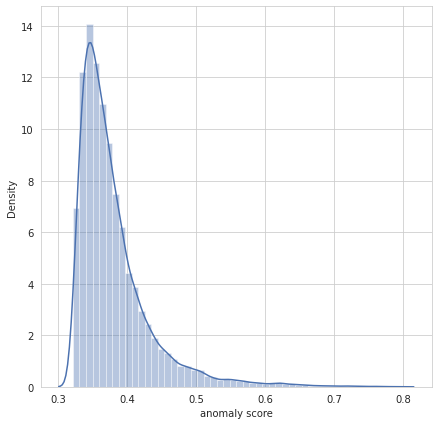

In [28]:
visualize(exp_ntrees_results[10])

- **sample size에 따른 성능 변화**

In [15]:
exp_ss = [128, 256, 512]
exp_ss_results = {}
exp_ss_forests = []
for ss in exp_ss:
    print("="*100)
    print(f'Number of Sample Size : {ss}')
    F = iForest(train_dataset, ntrees=10, sample_size=ss)
    S_val = F.compute_paths(X_in=val_dataset_attributes)
    exp_ss_results[ss] = S_val
    exp_ss_forests.append(F)
    show_result(S_val)

Number of Sample Size : 128


Constructing Tree...:   0%|          | 0/10 [00:00<?, ?it/s]

Computing path...:   0%|          | 0/28462 [00:00<?, ?it/s]

Threshold: 0.5 => Macro F1-Score: 0.483
Threshold: 0.6 => Macro F1-Score: 0.519
Threshold: 0.7 => Macro F1-Score: 0.499
Threshold: 0.8 => Macro F1-Score: 0.5
Threshold: 0.9 => Macro F1-Score: 0.5
⭐️ Best F1-Score : 0.519
Number of Sample Size : 256


Constructing Tree...:   0%|          | 0/10 [00:00<?, ?it/s]

Computing path...:   0%|          | 0/28462 [00:00<?, ?it/s]

Threshold: 0.5 => Macro F1-Score: 0.5
Threshold: 0.6 => Macro F1-Score: 0.554
Threshold: 0.7 => Macro F1-Score: 0.614
Threshold: 0.8 => Macro F1-Score: 0.5
Threshold: 0.9 => Macro F1-Score: 0.5
⭐️ Best F1-Score : 0.614
Number of Sample Size : 512


Constructing Tree...:   0%|          | 0/10 [00:00<?, ?it/s]

Computing path...:   0%|          | 0/28462 [00:00<?, ?it/s]

Threshold: 0.5 => Macro F1-Score: 0.515
Threshold: 0.6 => Macro F1-Score: 0.599
Threshold: 0.7 => Macro F1-Score: 0.707
Threshold: 0.8 => Macro F1-Score: 0.5
Threshold: 0.9 => Macro F1-Score: 0.5
⭐️ Best F1-Score : 0.707


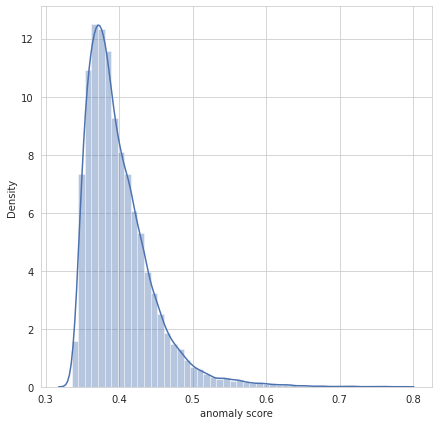

In [31]:
visualize(exp_ss_results[512])

---

## 2️⃣ Remove Randomness using Information gain
> Split하는 기준이 되는 Attribute를 데이터의 Attributes 중에서 랜덤하게 선택하지 않고, Information Gain이 최대가 되는 Attribute를 찾아서 해당 Attribute를 기준으로 Split하는 실험을 진행해보았습니다. 과연 논문에서 이야기하는 "랜덤 선택"과 비교하여 성능이 어떻게 달라지게 될까요?🤔
- Reference
    - http://deerishi.github.io/Decision-Tree-in-Python-for-Continuous-Attributes/
    - https://community.rapidminer.com/discussion/58166/decision-tree-without-a-label-is-it-possible
    - https://towardsdatascience.com/entropy-and-information-gain-in-decision-trees-c7db67a3a293

### Step 1 : Pseudo Label 구축
> Information gain을 통해 Decision Tree를 구축하기 위해서 필요한 Label 정보가 현재 Train Dataset에는 없으므로 한번 학습을 진행한 Isolation Forest를 통해 Pseudo Label을 구축하겠습니다.


In [16]:
def get_pseudo_label(dataset):
    # 가장 성능이 좋았던 n_tree=10, sample_size=512의 Isolation Forest 모델 사용
    S_train = exp_ss_forests[-1].compute_paths(X_in=train_dataset)
    pseudo_label = np.where(S_train >= 0.7, 1, 0)
    return pseudo_label

In [17]:
train_dataset_copy = train_dataset.copy()

In [18]:
train_dataset_copy['pseudo_label'] = get_pseudo_label(train_dataset_copy)

Computing path...:   0%|          | 0/113842 [00:00<?, ?it/s]

In [19]:
train_dataset_label = train_dataset_copy['pseudo_label']

In [167]:
train_dataset_attributes = train_dataset_copy.drop(columns=['pseudo_label'])[['V14', 'V12', 'V10', 'V3', 'V9', 'V6', 'V16', 'V17', 'V7', 'V18', 'V1', 'V5', 'V2', 'V11', 'V4']]

### Step 2 : 학습 진행
> 랜덤하게 샘플링되는 데이터에 label이 1, 즉 사기 거래인 데이터가 포함될 확률이 매우매우 적기 때문에 IG가 다 0으로 계산되는 일이 발생했습니다. 애초에 극도로 불균형 데이터에 Information Gain을 활용한다는게 말이 안되는걸(그래서 논문에서 랜덤을 반복한 것 같다는 사실을) 깨달았지만 이왕 여기까지 온거 결과가 어떻게 되건 끝까지 가보자는 마음으로 몇 가지 매뉴얼한 요소를 추가했습니다.

> ① 데이터를 샘플링할 때 전체 sample 데이터 중 반드시 label이 1인 데이터가 10~20개는 포함되도록 재구성했습니다.

> ② Information Gain을 구하는데 시간이 오래 소요되기 때문에 데이콘 대회의 게시글을 참고하여 correlation value가 유의미한 15개의 feature만 학습에 사용했고, Tree의 Height을 10으로 제한을 뒀습니다.

- Continuous Attributes에 대해 Information Gain을 구하는 방법은 다음과 같습니다.
<img src="images/if_threshold.png" width="500">

    - 이미지 출처 : https://www.mldawn.com/the-decision-tree-algorithm-information-gain/

In [148]:
class CustomiForest(object):
    def __init__(self, X, labels, ntrees, sample_size, limit=None):
        self.ntrees = ntrees 
        self.X = X
        self.labels = labels
        self.nobjs = len(X)
        self.sample = sample_size 
        self.Trees = []
        self.limit = limit
        if limit is None:
            self.limit = int(np.ceil(np.log2(self.sample)))
        self.c = c_factor(self.sample)
        for i in tqdm(range(self.ntrees), desc="Constructing Tree..."):
            label_1_num = random.randint(10, 20)
            label_0_num = self.sample - label_1_num
            label_0 = self.X.loc[np.where(self.labels==0)[0]]
            label_1 = self.X.loc[np.where(self.labels==1)[0]]
            label_0_ix = label_0.index[random.sample(range(len(label_0)), label_0_num)].tolist()
            label_1_ix = label_1.index[random.sample(range(len(label_1)), label_1_num)].tolist()
            ix = label_0_ix + label_1_ix
            X_p = X.loc[ix]
            labels_p = labels.loc[ix]
            self.Trees.append(CustomiTree(X_p, 0, self.limit, labels_p))

    def compute_paths(self, X_in = None):
        if X_in is None:
            X_in = self.X
        S = np.zeros(len(X_in))
        for i in  tqdm(range(len(X_in)), desc="Computing path..."):
            h_temp = 0
            for j in range(self.ntrees):
                h_temp += PathFactor(X_in.loc[i], self.Trees[j]).path*1.0
            Eh = h_temp / self.ntrees
            S[i] = 2.0**(-Eh/self.c)
        return S

In [170]:
class CustomiTree(object):
    def __init__(self, X, e, l, labels):
        self.e = e  
        self.X = X 
        self.labels = labels
        self.Q = list(X.columns)
        self.usedThresholds = {}
        for attr in self.Q:
            self.usedThresholds[attr] = set()
        self.size = len(X)
        self.l = l
        self.p = None
        self.q = None
        self.exnodes = 0 
        self.root = self.make_tree(X, e, l)
        
    def make_tree(self, X, e, l):
        self.e = e
        
        if e >= l or len(X) <= 1:
            left = None
            right = None
            self.exnodes += 1
            return Node(X, self.q, self.p, e, left, right, node_type = 'exNode')
        else:
            # 📌 Split하는 기준이 되는 Attribute를 Information Gain이 최대가 되는 Attribute로 선정
            IGA=[]
            thresholds=[]
            for attr in self.Q:
                thresh, IG = self.findThresholdAndIG(attr)
                IGA.append(IG)
                thresholds.append(thresh)
            maxIG = max(IGA)
            self.q = self.Q[IGA.index(maxIG)]
            mini = X[:][self.q].min()
            maxi = X[:][self.q].max()
            if mini==maxi:
                left = None
                right = None
                self.exnodes += 1
                return Node(X, self.q, self.p, e, left, right, node_type = 'exNode')
            
            self.p = random.uniform(mini, maxi)
            
            w = np.where(X[:][self.q] < self.p, True, False)
            return Node(X, self.q, self.p, e,\
                        left=self.make_tree(X[w], e+1, l),\
                        right=self.make_tree(X[~w], e+1, l),\
                        node_type = 'inNode')

    def get_node(self, path):
        node = self.root
        for p in path:
            if p == 'L' : node = node.left
            if p == 'R' : node = node.right
        return node
    
    def findIG(self, threshold, attr):
        data = self.X.copy()
        labels = self.labels.copy()
        labels = labels.reset_index()
        
        rowsLeft = np.where(data[:][attr] >= threshold)[0]
        rowsRight = np.where(data[:][attr] < threshold)[0]
        rows0 = np.where(labels==0)[0]
        rows1 = np.where(labels==1)[0]
        p0 = float(rows0.shape[0])/labels.shape[0]
        p1 = float(rows1.shape[0])/labels.shape[0]
        if p0==0 or p1==0:
            HX = 0
        else:
            HX = -1*p0*np.log2(p0) - p1*np.log2(p1)
        
        # Calculate the H(Y|X) 
        labelsLeft = labels.loc[rowsLeft]
        labelsRight = labels.loc[rowsRight]
        
        # For Left Child
        rows0 = np.where(labelsLeft==0)[0]
        rows1 = np.where(labelsLeft==1)[0]
        
        p0L = float(rows0.shape[0])/labelsLeft.shape[0]
        p1L = float(rows1.shape[0])/labelsLeft.shape[0]
        if p0L==0 or p1L==0:
            HY_X_L = 0
        else:
            HY_X_L = -1*p0L*np.log2(p0L) - p1L*np.log2(p1L)
            HY_X_L = HY_X_L*float(rowsLeft.shape[0])/data.shape[0]
        
        # For Right Child
        rows0 = np.where(labelsRight==0)[0]
        rows1 = np.where(labelsRight==1)[0]
        p0R = float(rows0.shape[0])/labelsRight.shape[0]
        p1R = float(rows1.shape[0])/labelsRight.shape[0]
        if p0R == 0 or p1R == 0:
            HY_X_R = 0
        else:
            HY_X_R = -1*p0R*np.log2(p0R) - p1R*np.log2(p1R)
            HY_X_R = HY_X_R*float(rowsRight.shape[0])/data.shape[0]
        
        IG = HX - HY_X_L - HY_X_R
        return IG     
    
    def findThresholdAndIG(self, attr):
        data = self.X.copy()
        labels = self.labels.copy()
        values = sorted(set(data[:][attr]))
        toTryThreshholds=[]
        for i in range(0, len(values)-1):
            toTryThreshholds.append((values[i]+values[i+1])/2)
        toTryThreshholds = set(toTryThreshholds)
        if attr in self.usedThresholds:
            for used in self.usedThresholds[attr]:
                if used in toTryThreshholds:
                    toTryThreshholds.remove(used)
        
        toTryThreshholds = sorted(toTryThreshholds)
        IG = []
        for threshold in toTryThreshholds:
            IG.append(self.findIG(threshold, attr))
        
        maxIG = max(IG)
        maxThresh = IG.index(maxIG)
        
        return toTryThreshholds[maxThresh], maxIG

In [171]:
IGF = CustomiForest(train_dataset_attributes, train_dataset_label, ntrees=10, sample_size=256, limit=10)

Constructing Tree...:   0%|          | 0/10 [00:00<?, ?it/s]

In [177]:
OF = iForest(train_dataset_attributes, ntrees=10, sample_size=256, limit=10)

Constructing Tree...:   0%|          | 0/10 [00:00<?, ?it/s]

In [174]:
S_igf_val = IGF.compute_paths(X_in=val_dataset_attributes)
S_of_val = OF.compute_paths(X_in=val_dataset_attributes)

Computing path...:   0%|          | 0/28462 [00:00<?, ?it/s]

Computing path...:   0%|          | 0/28462 [00:00<?, ?it/s]

---
## 3️⃣ Original IF vs Information Gain IF
> 3시간의 기다림이 무색하게 랜덤하게 Attribute를 선택한 결과가 Information Gain을 기준으로 선택한 결과보다 Validation Dataset에 대해서도, Test Dataset에서도 더 높은 Macro F1-Score를 보였습니다. 비록 코드를 더 효율적으로 수정하면 학습 시간을 단축시킬 순 있겠지만 Information Gain을 계산하는 시간을 고려하면 랜덤하게 선택할 때보단 시간이 더 소요될 것이고, 성능도 시간 관계상 다양한 세팅으로 진행하지 못한만큼 절대적인 비교라고 보긴 어렵지만 아마 다른 세팅에서도 비슷하거나 더 낮은 성능을 보일 것으로 예상됩니다. 이로써 논문에서 Attribute를 선택할 때나 Split Point를 선택할 때 "랜덤"하게 진행한 것은 **학습 시간과 성능 모두를 고려한 결과**였다는 사실을 해당 노트북 실험을 통해 깨닫게 됐습니다...💡 (유튜브 영상을 만들 때까지만 해도 랜덤하게 진행하는 부분들은 왠지 모르게 신뢰가 가지 않았는데 이제와 생각해보니 여러 시행 착오 끝에 나온 결론이었을 것 같다는 생각이 듭니다.)

- **Original IF Validation Dataset 결과**

In [185]:
show_result(S_of_val)

Threshold: 0.5 => Macro F1-Score: 0.48
Threshold: 0.6 => Macro F1-Score: 0.54
Threshold: 0.7 => Macro F1-Score: 0.668
Threshold: 0.8 => Macro F1-Score: 0.75
Threshold: 0.9 => Macro F1-Score: 0.5
⭐️ Best F1-Score : 0.75


- **Original IF Test Dataset 결과** (데이콘에 제출해서 얻은 결과)
    - Public Score : 0.6004
    - Private Score : 0.6222

- **Information Gain IF Validation Dataset 결과** (무려 3시간이 소요된...)

In [176]:
show_result(S_igf_val)

Threshold: 0.5 => Macro F1-Score: 0.484
Threshold: 0.6 => Macro F1-Score: 0.539
Threshold: 0.7 => Macro F1-Score: 0.643
Threshold: 0.8 => Macro F1-Score: 0.5
Threshold: 0.9 => Macro F1-Score: 0.5
⭐️ Best F1-Score : 0.643


- **Information Gain IF Test Dataset 결과** (데이콘에 제출해서 얻은 결과)
    - Public Score : 0.5433
    - Private Score : 0.5706

> 유튜브 영상을 제작하면서 들었던 궁금증을 해결할 수 있었던 유익한 시간이었습니다. 그럼 다음 튜토리얼에 **`Ensemble Learning`**으로 다시 찾아뵙겠습니다.

<img src="images/9_turtle.png" width="300">

> +) 데이콘에 여러 Test 인퍼런스 파일을 제출해본 결과 가장 잘 나온 성능은 다음과 같았습니다. 비록 절대적인 점수는 낮지만, 라이브러리를 사용하지 않고 기타적인 튜닝을 하지 않은 것치고 준수한 성능이 나왔다고 생각합니다😀


<img src="images/if_dacon.png" width="200">